In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from torch.utils.data import DataLoader
from typing import Optional, Tuple, List, Union, Callable
from dataset import DigitalTwinDataset, device
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

MPS (GPU) is available.


## 1. Data Preparation

In [2]:
# Define dataset hyperparameters
sample_length = 512
sample_length_flat = sample_length * 6
shuffle_data = True

# Create train and valid dataset
train_dataset = DigitalTwinDataset("new_data/all_data/train/", sample_length, device, shuffle_data)
valid_dataset = DigitalTwinDataset("new_data/all_data/test/", sample_length, device, shuffle_data)

print('Train Dataset: ', len(train_dataset))
print('Valid Dataset: ', len(valid_dataset))

Train Dataset:  2082
Valid Dataset:  1552


In [3]:
# Create dataloaders for the three datsets
batch_size = 32 
shuffle = True

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)

In [4]:
def format_target(target, pred_screw_loc=False):
    '''
    Converts int/float targets to multi-label targets. (i.e., 0 to [0,0,0,0], 1 to [1,1,0,0], 
    2 to [1,0,1,0], and [1,0,0,1]). The first item corresponds to whether there is an imbalance in
    the system or not, while the last 3 values correspond to the mass location of the imabalance
    '''
    target = torch.tensor(target)

    # Get class output
    output = torch.where(target==0, 0, 1).reshape(-1,1)

    # Get screw location output if enabled
    if pred_screw_loc:
        output = torch.concat([output, torch.where(target==1, 1, 0).reshape(-1,1)], dim=-1)
        output = torch.concat([output, torch.where(target==2, 1, 0).reshape(-1,1)], dim=-1)
        output = torch.concat([output, torch.where(target==3, 1, 0).reshape(-1,1)], dim=-1)

    return output.type(torch.float32)

labels = format_target(train_dataset.labels, pred_screw_loc=True)
train_dataset.labels[:5], labels[:5]

([tensor(2), tensor(3), tensor(3), tensor(2), tensor(0)],
 tensor([[1., 0., 1., 0.],
         [1., 0., 0., 1.],
         [1., 0., 0., 1.],
         [1., 0., 1., 0.],
         [0., 0., 0., 0.]]))

## 2. Model Archtecture

In [5]:
class CNN(nn.Module):
    def __init__(
            self,
            d_input: int = 512,
            d_input_channels: int = 6,
            n_layers: int = 6,
            d_cnn_filter: int = 128,
            d_mlp_filter: int = 256,
            skip: Tuple[int] = (2,4),
            class_pred_threshold: float = 0.5,
            pred_screw_loc: Optional[bool] = False,
        ):
        super().__init__()
        self.d_input_channels = d_input_channels
        self.skip = skip
        self.activation = nn.functional.relu
        self.pred_screw_loc = pred_screw_loc
        self.class_pred_threshold = class_pred_threshold

        # Create model hidden layers using 1D convolutional layers
        self.layers = nn.ModuleList(
            [nn.Conv1d(self.d_input_channels, d_cnn_filter, kernel_size=5, padding='same')] +
            [nn.Conv1d(d_cnn_filter + self.d_input_channels, d_cnn_filter, kernel_size=5, padding='same') if i in skip \
            else nn.Conv1d(d_cnn_filter, d_cnn_filter, kernel_size=5, padding='same') for i in range(n_layers - 1)]
        )

        # Create model output layer for binary classification
        self.pool = nn.AvgPool1d(7, stride=2, padding=3)
        self.class_branch = nn.Linear(d_input//2 * d_cnn_filter, d_mlp_filter)
        self.class_out = nn.Linear(d_mlp_filter, 1)

        # Add extra layers to predict screw locations if enabled
        if self.pred_screw_loc:
            self.input_branch = nn.Linear(d_mlp_filter + 1, d_mlp_filter)
            self.branch = nn.Linear(d_mlp_filter, d_mlp_filter)
            self.loc_out = nn.Linear(d_mlp_filter, 3)

    def forward(
            self,
            x: torch.Tensor,
        ) -> torch.Tensor:
        """
        Forward pass.
        """
        x = x.permute(0, 2, 1)  # Change input shape to (batch, 6, 512)
        x_input = x 
        for i, layer in enumerate(self.layers):
            x = self.activation(layer(x))
            # Concatenate input with prev layer output if layer index is in skip
            if i in self.skip:
                x = torch.cat([x, x_input], dim=1) 

        # Classify signal into healthy/unhealthy signal
        x = self.pool(x)
        # x = x.mean(dim=2)
        x = x.flatten(start_dim=1).type(torch.float32)
        x = self.activation(self.class_branch(x))
        class_out = torch.sigmoid(self.class_out(x))  # Global average pooling over the time dimension

        # Predict screw locations if enabled
        if self.pred_screw_loc:
            # Concatenate signal class prediction with the last layer feature vector
            x = torch.cat([x, class_out], dim=1)  

            # Implement a forward pass on the extra layers
            x = self.activation(self.input_branch(x))
            x = self.activation(self.branch(x))
            init_loc_out = torch.sigmoid(self.loc_out(x))

            # Mask the model output such that the location output is dependent on the class output
            # (i.e., set screw locations to 0 where class prediction is below classification threshold)
            mask = class_out < self.class_pred_threshold
            loc_out = init_loc_out.clone()
            loc_out[mask.expand(loc_out.shape)] = 0.0  

            # Concatenate class_out and modified screw locations
            x = torch.cat([class_out, loc_out], dim=1) 
        else:
            # If not predicting screw locations, output only class prediction
            x = class_out  

        return x
    
cnn = CNN(pred_screw_loc=True)
output = cnn(valid_dataset.data[0].unsqueeze(dim=0).type(torch.float32))
print(output)


tensor([[0.5049, 0.4926, 0.4822, 0.4885]], grad_fn=<CatBackward0>)


## 3. Model Training and Evaluation

In [6]:
def evaluate_model(model, dataloader, pred_screw_loc=True, device='cpu',):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            X = data["data"].type(torch.float32) 
            y = data["label"].type(torch.float32)
            y = format_target(y, pred_screw_loc=pred_screw_loc)
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred = torch.where(y_pred > 0.5, 1, 0)

            correct += sum(y == y_pred)
            total += len(y)

    accuracy = np.round((correct/total).detach().cpu().numpy(), 2)
    return accuracy


In [7]:
def get_loss(model, dataloader, criterion, pred_screw_loc=True, device='cpu'):
    model.eval()
    running_loss = 0
    running_examples = 0

    with torch.no_grad():
        for data in dataloader:
            X = data["data"].type(torch.float32) 
            y = data["label"].type(torch.float32)
            y = format_target(y, pred_screw_loc=pred_screw_loc)
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            running_loss += loss
            running_examples += len(X)

    loss = np.round((running_loss/running_examples).detach().cpu().numpy(), 2)
    return loss


In [8]:
def train_model(
        model, 
        train_dataloader, 
        valid_dataloader, 
        criterion, 
        optimizer, 
        scheduler = None,
        pred_screw_loc=True, 
        n_epochs=100, 
        device='cpu'
        ):
    model.train()

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    

    for epoch in range(n_epochs):
        iter = 0
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(train_dataloader):
            # Split batch to inputs and targets
            X = batch["data"].type(torch.float32)
            y = batch["label"].type(torch.float32)
            y = format_target(y, pred_screw_loc=pred_screw_loc)
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X).type(torch.float32)
          
            # Calculate loss
            loss = criterion(y_pred, y)
            running_loss += loss
            running_examples += len(X)

            # Zero the Optimizer gradients
            optimizer.zero_grad()

            # Compute parameters gradients using the Loss backward
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Update learning rate using scheduler
        if scheduler is not None:
            scheduler.step()

        # Evaluate model performance using train and validation data
        train_accuracy = evaluate_model(model, train_dataloader, pred_screw_loc, device)
        valid_accuracy = evaluate_model(model, valid_dataloader, pred_screw_loc, device)

        # Get train and validation loss
        train_loss = get_loss(model, train_dataloader, criterion, pred_screw_loc, device)
        valid_loss = get_loss(model, valid_dataloader, criterion, pred_screw_loc, device)
        
        # Save Losses and Accuracies
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)


        # Display loss after every epoch
        print(
            f'Epoch: {epoch+1}, lr: {optimizer.param_groups[0]["lr"] :.2}, Train loss: {running_loss/running_examples:.2}, Train Acc: {train_accuracy}, Validation Acc: {valid_accuracy}'
            )

        iter += 1
    
    return np.array(train_losses), np.array(valid_losses), np.array(train_accuracies), np.array(valid_accuracies)

In [9]:
# Define a seed for model re-implementation
torch.manual_seed(42)

# Instantiate a model
n_epochs = 200
pred_screw_loc = True
cnn_model = CNN(d_input_channels=6, pred_screw_loc=pred_screw_loc)
cnn_model.to(device)

# Define an optimizer for the model
learning_rate = .005
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Define a scheduler for the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//4, gamma=0.5)

# Define a Loss funtion
criterion = torch.nn.BCELoss()

# Train the model
torch.autograd.set_detect_anomaly(True)
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model=cnn_model, 
    train_dataloader=train_data_loader, 
    valid_dataloader=valid_data_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    pred_screw_loc=pred_screw_loc, 
    n_epochs=n_epochs, 
    device=device
    )

/var/folders/k4/jh0nr8sn1_760ttpt87c4z9c0000gn/T/ipykernel_1309/4000835048.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Epoch: 1, lr: 0.005, Train loss: 0.11, Train Acc: [0.71 0.81 0.81 0.81], Validation Acc: [0.76 0.75 0.75 0.75]
Epoch: 2, lr: 0.005, Train loss: 0.13, Train Acc: [0.74 0.84 0.78 0.81], Validation Acc: [0.78 0.78 0.71 0.75]
Epoch: 3, lr: 0.005, Train loss: 0.15, Train Acc: [0.77 0.94 0.82 0.81], Validation Acc: [0.69 0.91 0.75 0.74]
Epoch: 4, lr: 0.005, Train loss: 0.15, Train Acc: [0.81 0.95 0.95 0.81], Validation Acc: [0.75 0.93 0.93 0.75]
Epoch: 5, lr: 0.005, Train loss: 0.14, Train Acc: [0.76 0.88 0.88 0.81], Validation Acc: [0.8  0.85 0.84 0.75]
Epoch: 6, lr: 0.005, Train loss: 0.14, Train Acc: [0.86 0.98 0.98 0.86], Validation Acc: [0.79 0.98 0.98 0.79]
Epoch: 7, lr: 0.005, Train loss: 0.12, Train Acc: [0.86 0.98 0.98 0.86], Validation Acc: [0.82 0.97 0.98 0.82]
Epoch: 8, lr: 0.005, Train loss: 0.092, Train Acc: [0.9  0.95 0.95 0.9 ], Validation Acc: [0.85 0.93 0.93 0.85]
Epoch: 9, lr: 0.005, Train loss: 0.081, Train Acc: [0.85 1.   1.   0.85], Validation Acc: [0.84 1.   1.   0.84]

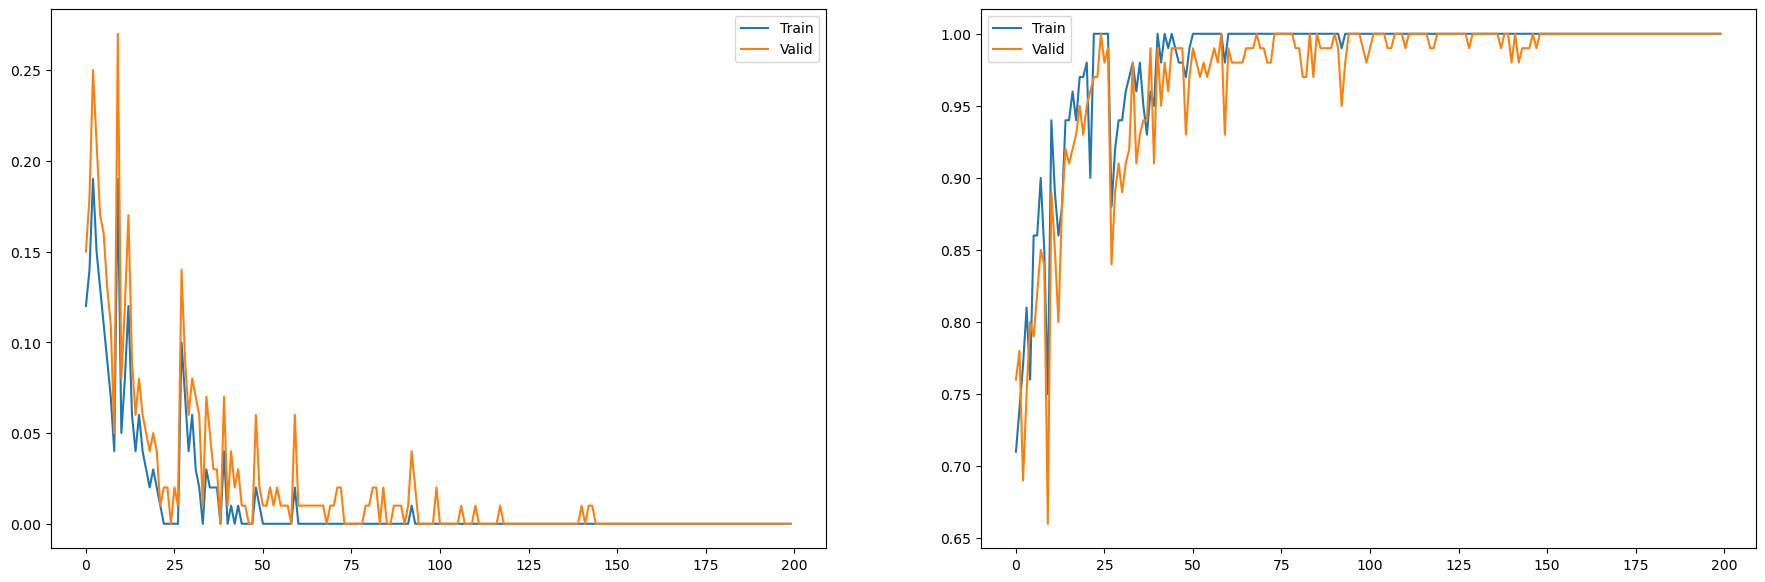

In [10]:
fig, axis = plt.subplots(1,2, figsize=(22,7))
axis[0].plot(train_losses)
axis[0].plot(valid_losses)
axis[0].legend(['Train', 'Valid'])

axis[1].plot(train_accuracies[:,0])
axis[1].plot(valid_accuracies[:,0])
axis[1].legend(['Train', 'Valid'])

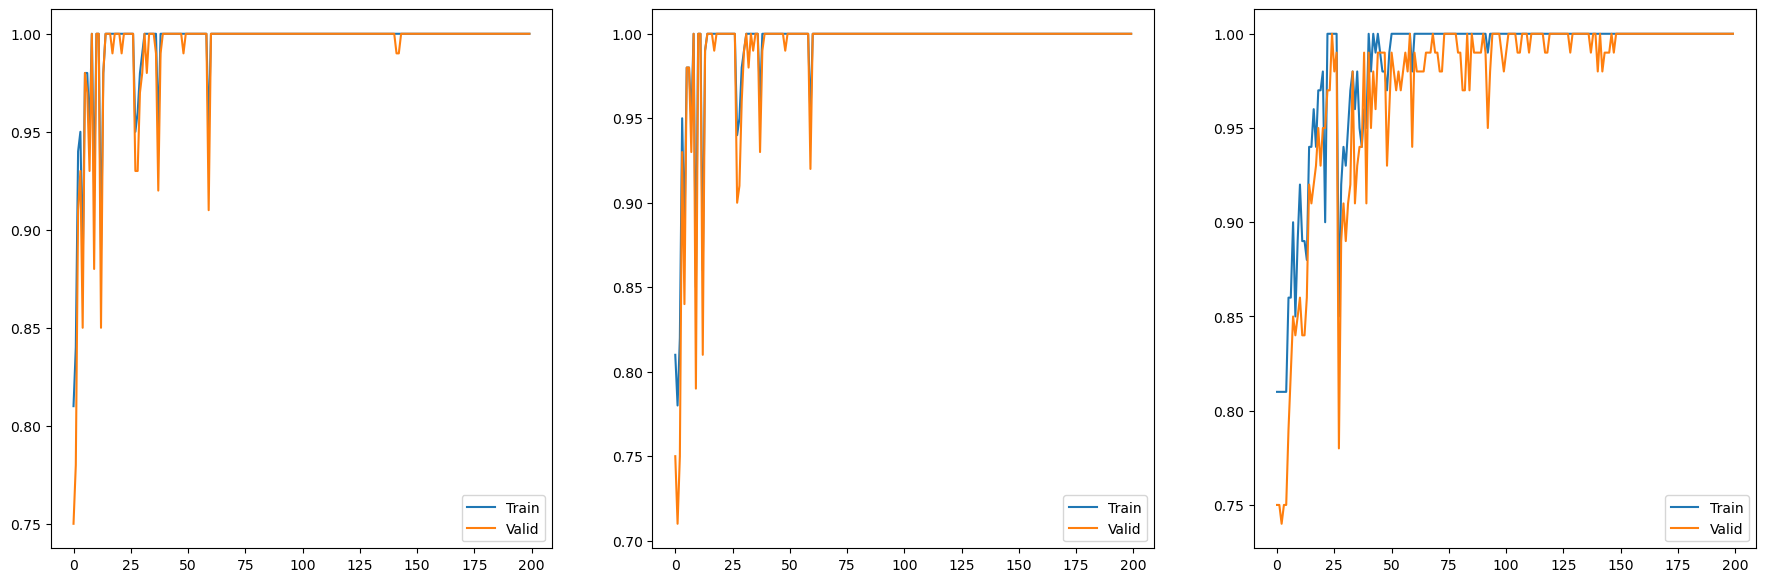

In [11]:
fig, axis = plt.subplots(1,3, figsize=(22,7))
for i in range(1,4):
    axis[i-1].plot(train_accuracies[:,i])
    axis[i-1].plot(valid_accuracies[:,i])
    axis[i-1].legend(['Train', 'Valid'])

## 4. Model Performance Evaluation

In [12]:
train_accuracy = evaluate_model(cnn_model, train_data_loader, pred_screw_loc=pred_screw_loc, device=device)
test_accuracy = evaluate_model(cnn_model, valid_data_loader, pred_screw_loc=pred_screw_loc, device=device)
print(f'Accuracy of the network on the train data: {train_accuracy}')
print(f'Accuracy of the network on the test data: {test_accuracy}')

/var/folders/k4/jh0nr8sn1_760ttpt87c4z9c0000gn/T/ipykernel_1309/4000835048.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Accuracy of the network on the train data: [1. 1. 1. 1.]
Accuracy of the network on the test data: [1. 1. 1. 1.]


In [13]:
def predict_targets(model, dataloader, pred_screw_loc=True, device='cpu'):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for data in dataloader:
            X = data["data"].type(torch.float32) 
            y = data["label"].type(torch.float32)
            y = format_target(y, pred_screw_loc=pred_screw_loc)
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred = torch.where(y_pred > 0.5, 1, 0)
            predictions.append(y_pred)
            targets.append(y)

        predictions = torch.concat(predictions, dim=0).cpu().detach().numpy()
        targets = torch.concat(targets, dim=0).cpu().detach().numpy()

    return targets, predictions

In [14]:
train_targets, train_predictions = predict_targets(cnn_model, train_data_loader, pred_screw_loc=pred_screw_loc, device=device)
valid_targets, valid_predictions = predict_targets(cnn_model, valid_data_loader, pred_screw_loc=pred_screw_loc, device=device)

/var/folders/k4/jh0nr8sn1_760ttpt87c4z9c0000gn/T/ipykernel_1309/4000835048.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


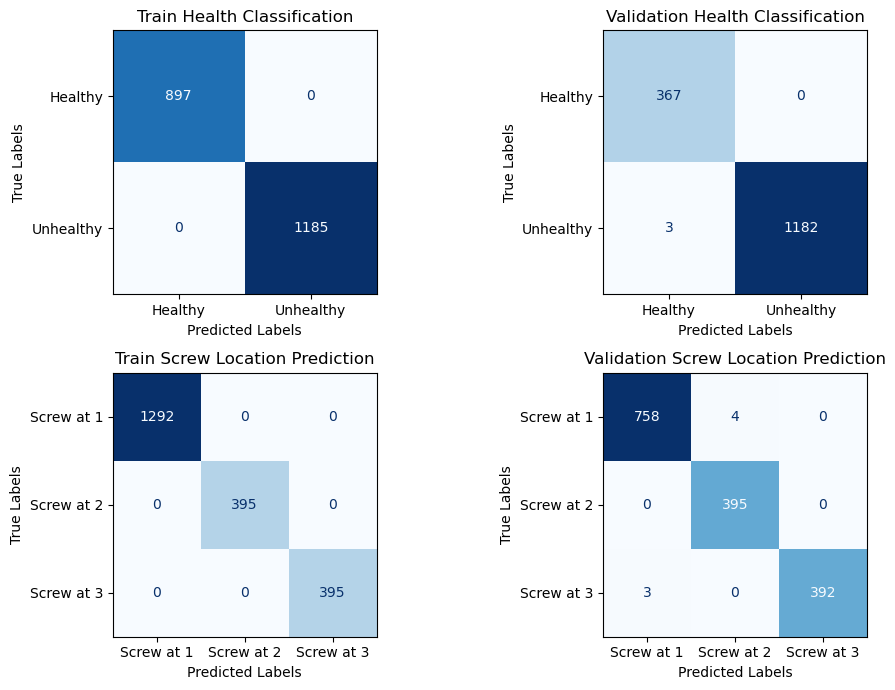

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(10, 7))
idxs = [(0,0),(0,1), (1,0), (1,1)]
class_labels = (
    ['Healthy', 'Unhealthy'], 
    ['Healthy', 'Unhealthy'], 
    ['Screw at 1', 'Screw at 2', 'Screw at 3'], 
    ['Screw at 1', 'Screw at 2', 'Screw at 3'],
    )
titles = (
    'Train Health Classification', 
    'Validation Health Classification', 
    'Train Screw Location Prediction', 
    'Validation Screw Location Prediction',
    )

pred_values = (
    [train_targets[:,0], train_predictions[:,0]], 
    [valid_targets[:,0], valid_predictions[:,0]],
    [np.argmax(train_targets[:,1:], axis=-1), np.argmax(train_predictions[:,1:], axis=-1)],
    [np.argmax(valid_targets[:,1:], axis=-1), np.argmax(valid_predictions[:,1:], axis=-1)],
    )

for labels, title, pred, idx in zip(class_labels, titles, pred_values, idxs):
    cm = confusion_matrix(pred[0], pred[1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    i, j = idx
    disp.plot(ax=axis[i,j], cmap=plt.cm.Blues, values_format='d')
    disp.im_.colorbar.remove()
    axis[i,j].set_title(title)
    axis[i,j].set_xlabel('Predicted Labels')
    axis[i,j].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


## 5. Save Model

In [16]:
# Save the trained model if needed
torch.save(cnn_model.state_dict(), 'checkpoints/cnn_model_1.pth')